### About the use case:- Recognition bird by songbird

Using Spark, we obtain data in Kaggle about bird's songs. This file contains birdsongs about 91 bird species. We recover 5 species with 10 samples each bird. 

In [1]:
#!wget https://download.java.net/java/GA/jdk13.0.1/cec27d702aa74d5a8630c65ae61e4305/9/GPL/openjdk-13.0.1_linux-x64_bin.tar.gz
#!tar xvfz openjdk-13.0.1_linux-x64_bin.tar.gz
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark
import os
#os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/home/dsxuser/work/spark-2.4.4-bin-hadoop2.7"
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType, StringType
#sc = SparkSession.builder.master("local[*]").getOrCreate()
#Spark Contexto
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .getOrCreate()

In [2]:
from pyspark import SparkConf
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType, StringType
from pyspark.sql.functions import *
from pyspark import SparkContext
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.window import *
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, Normalizer, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

In [3]:
import scipy.io.wavfile as waves
from scipy import signal

import numpy as np

from io import BytesIO

import matplotlib.pyplot as plt

try:
    import librosa
except:   
    !pip install librosa==0.6.1
    import librosa

In [4]:
!rm -Rf pruebas
!git clone https://github.com/dianillaml/datos-publico

Cloning into 'datos-publico'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 1544 (delta 21), reused 2 (delta 1), pack-reused 1499
Receiving objects: 100% (1544/1544), 3.30 GiB | 45.80 MiB/s, done.
Resolving deltas: 100% (45/45), done.
Checking out files: 100% (451/451), done.


In [5]:
#content bird songs information file
!wget 'https://raw.githubusercontent.com/dianillaml/datos-publico/master/xeno-canto_ca-nv_index.csv'

--2020-01-15 17:31:36--  https://raw.githubusercontent.com/dianillaml/datos-publico/master/xeno-canto_ca-nv_index.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.60.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.60.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2141683 (2.0M) [text/plain]
Saving to: ‘xeno-canto_ca-nv_index.csv.5’

100%[======================================>] 2,141,683   --.-K/s   in 0.09s   

2020-01-15 17:31:36 (23.2 MB/s) - ‘xeno-canto_ca-nv_index.csv.5’ saved [2141683/2141683]



In [6]:
os.getcwd()

'/home/dsxuser/work'

In [7]:
df = spark.read.format("csv").load("file:///home//dsxuser//work//xeno-canto_ca-nv_index.csv",header='true')

In [8]:
df.createOrReplaceTempView('df')
df_birdsong = spark.sql('select duration_seconds, english_cname, genus, species, file_name from df')
#change file extension for manipulating
df_birdsong = df_birdsong.withColumn('file_name', regexp_replace('file_name', 'mp3', 'wav'))

In [9]:
d = '/home/dsxuser/work/datos-publico'
os.chdir('/home/dsxuser/work/datos-publico')

In [10]:
sqlContext = SQLContext(sc)

In [11]:
#new dataframe with all files in folder

files_df = sqlContext.createDataFrame(zip((os.listdir(d))), schema=['file_name']) 
#I only want wav files and remove the rest
files_df = files_df.filter(files_df.file_name.like('%.wav%'))

In [12]:
#new dataframe with the files found in folder 
final_df = files_df.join(df_birdsong, on=['file_name'], how='left_outer')

In [13]:
# I create different dataframes 
audio_data = []     ## audio data for each wav file
sampling_rate = []  ## audio rate
file_names = []     ## name of wav file  
name_bird = []      ## bird name

for i in range(final_df.count()):
#for i in range(0, 100):

    audio_file = final_df.select(final_df.file_name).collect()[i][0]
    name = final_df.select(final_df.english_cname).collect()[i][0]
    
    if audio_file is not None:
        file_names.append(audio_file)
        name_bird.append(name)
        samplerate, data = waves.read(audio_file)
        audio_data.append(data.astype(float))
        sampling_rate.append(samplerate)   

In [14]:
#normalize samplerate to same rate and mono
for index in range(len(audio_data)):
    
    if (sampling_rate[index] != 44100):
        audio_data[index] = librosa.resample(audio_data[index], sampling_rate[index], 44100)
        sampling_rate[index] = 44100
        
def to_mono(data):
    if data.ndim > 1:
        data = np.mean(data, axis=1)
    return data

for index in range(len(audio_data)):
    audio_data[index] = to_mono(audio_data[index])


In [15]:
#To avoid overfitting, we divide the audios into parts of a second of time
nuevo = []
for index in range(len(audio_data)):
    if len(audio_data[index]) > 44100:
        partes = len(audio_data[index]) // 44100
        total = partes * 44100 
        nuevo.append(np.split(audio_data[index][0:total], partes))
    else:
        total = len(audio_data[index])
        nuevo.append(np.split(audio_data[index][0:total], 1))
        

In [16]:
#Estimate power spectral density using Welch’s method
fs=44100
nperseg=128
freq = []
psd = []
file = []
bird=[]
for i1 in range(len(nuevo)):
    #print(len(nuevo))
    for i2 in range(len(nuevo[i1])):
        #print(len(nuevo[i1]), i1, i2)
        file.append(file_names[i1])
        bird.append(name_bird[i1])
        #indice.append(i1)
        f, p = signal.welch(nuevo[i1][i2], fs, 'hamming', nperseg)
        #sample frequencies
        freq.append(f)
        #Power spectral density
        psd.append(p.tolist())

In [82]:
#create new dataframe with file wav, bird name and psd data for use in the model
#df_valores = spark.createDataFrame(zip(file_names, name_bird, psd), schema=['file', 'name', 'values']) 
df_valores = spark.createDataFrame(zip(bird, file, psd), schema=['name','file','values']) 
#df_pd = pd.DataFrame(zip(bird, arr),columns = ['name', 'values'])

In [83]:
num_classes = classes.count()

In [84]:
from pyspark.sql import functions as F
from pyspark.sql.functions import row_number, lit
classes = df_valores.select(F.col('name')).distinct()
long = classes.count()
w = Window().orderBy(lit('A'))
classes = classes.withColumn("code", row_number().over(w))
classes.show()

+--------------------+----+
|                name|code|
+--------------------+----+
|    Wilson's Warbler|   1|
|California Gnatca...|   2|
|Yellow-breasted Chat|   3|
|  Mountain Chickadee|   4|
|Black-headed Gros...|   5|
|          Marsh Wren|   6|
|        Oak Titmouse|   7|
|Yellow-billed Magpie|   8|
|Nutting's Flycatcher|   9|
|Blue-grey Gnatcat...|  10|
|    Brewer's Sparrow|  11|
|Orange-crowned Wa...|  12|
|Nuttall's Woodpecker|  13|
|MacGillivray's Wa...|  14|
|    California Quail|  15|
|    Northern Flicker|  16|
|      Mountain Quail|  17|
|             Wrentit|  18|
+--------------------+----+



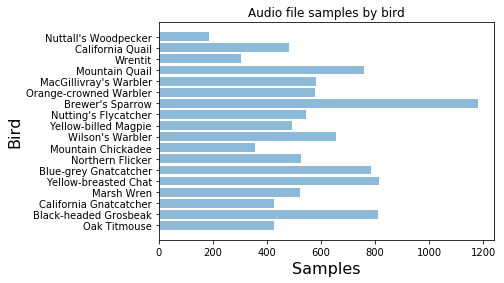

In [85]:
import collections
samples = collections.Counter(bird)
names = list(samples.keys())
values = list(samples.values())

ind = np.arange(num_classes)    # the x locations for the groups
width = 1       # the width of the bars: can also be len(x) sequence

plt.barh(ind, values, align='center', alpha=0.5)

plt.ylabel('Bird', fontsize=16)
plt.xlabel('Samples', fontsize=16)

plt.title('Audio file samples by bird')

plt.yticks(ind, names)
#plt.xticks(values)
#plt.legend((p1[0], p2[0]), ('Men', 'Women'))

plt.show()

In [ ]:
#transform power spectral density data to vector for work in the model
to_vector = udf(lambda a: Vectors.dense(a), VectorUDT())
data = df_valores.select("file", "name", to_vector("values").alias("values"))

In [ ]:
#ncode name column of labels to a column of label indices
indexer = StringIndexer(inputCol="name", outputCol="label")
indexed = indexer.fit(data).transform(data)

In [ ]:
#map a categorical feature, represented as a label index, to a binary vector
encoder = OneHotEncoder(inputCol = 'label', outputCol = 'categorized')
encoded = encoder.transform(indexed)

In [ ]:
#combine values columns into a single vector column
vector = VectorAssembler(inputCols = ['values'], outputCol='features')
vectored = vector.transform(encoded)

In [ ]:
#transform a dataset of Vector rows, normalizing each Vector to have unit norm
normalizer = Normalizer(inputCol="features", outputCol="features_norm", p=1.0)
normalized = normalizer.transform(vectored)

In [62]:
#split data into train and test
splits = normalized.randomSplit([0.8, 0.2])
df_train = splits[0]
df_test = splits[1]

In [ ]:
#apply Logistic Regression method
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
model = lr.fit(df_train)

In [ ]:
#create pipeline to run a sequence of the algorithms
#pipeline = Pipeline(stages=[indexer, encoder, vector, normalizer, lr])

In [91]:
#show the model accuracy with train data
prediction = model.transform(df_train)
binEval = MulticlassClassificationEvaluator().setMetricName("accuracy").setPredictionCol("prediction").setLabelCol("label")
binEval.evaluate(prediction) 

0.1140119760479042

In [92]:
#show the model accuracy with test data
prediction = model.transform(df_test)
binEval = MulticlassClassificationEvaluator().setMetricName("accuracy") .setPredictionCol("prediction").setLabelCol("label")   
binEval.evaluate(prediction) 

0.11014492753623188

In [93]:
# Print the coefficients and intercept for multinomial logistic regression
print("Coefficients: \n" + str(model.coefficientMatrix))
print("Intercept: " + str(model.interceptVector))

trainingSummary = model.summary

# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)

# for multiclass, we can inspect metrics on a per-label basis
print("False positive rate by label:")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("True positive rate by label:")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("Precision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("Recall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))

print("F-measure by label:")
for i, f in enumerate(trainingSummary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))

accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

Coefficients: 
18 X 65 CSRMatrix

Intercept: [0.7795962042213378,0.41410582221680275,0.3956157230114076,0.37360267185406904,0.34783671627440726,0.22104573312471046,0.11979729330988409,0.09279344124562998,0.00019786842271374424,-0.06416539419160334,-0.025511601262168823,-0.11209517547220459,-0.08406716769525656,-0.1624467400627527,-0.24158795931346605,-0.4145655933037357,-0.6194950374528483,-1.0206568049269265]
objectiveHistory:
2.8183541308703846
2.8183540355353958
2.818353821740694
2.8183537848147777
2.8183537462304766
2.818353732021429
2.8183537226218878
2.8183537200816255
2.818353719408188
2.818353719329529
False positive rate by label:
label 0: 1.0
label 1: 0.0
label 2: 0.0
label 3: 0.0
label 4: 0.0
label 5: 0.0
label 6: 0.0
label 7: 0.0
label 8: 0.0
label 9: 0.0
label 10: 0.0
label 11: 0.0
label 12: 0.0
label 13: 0.0
label 14: 0.0
label 15: 0.0
label 16: 0.0
label 17: 0.0
True positive rate by label:
label 0: 1.0
label 1: 0.0
label 2: 0.0
label 3: 0.0
label 4: 0.0
label 5: 0.0
lab